In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from salishsea_tools import viz_tools, places, visualisations
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from calendar import month_name
from scipy.io import loadmat
from tqdm.notebook import tqdm
from salishsea_tools import nc_tools
from dask.diagnostics import ProgressBar
import cmocean
from scipy.stats import sem
import scipy.stats as stats

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

### Load files from monthly averages

In [3]:

#years, months, data
monthly_array_silicon_depthint_slice = np.zeros([14,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)} 
e3t, tmask = [mask[var].isel(z=slice(None, 10),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2007, 2021), ['silicon']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}

# Loop through years
for year in [2007,2008,2009,2010,2011,2012,2016,2017,2018,2019,2020]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r/SalishSea_1m_{datestr}_{datestr}'
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            q = np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 10),**slc)*e3t*tmask).sum(axis=1)/((e3t*tmask).sum(axis=1)).data
            q2 = q[0,:,:]
            monthly_array_silicon_depthint_slice[year-2007,month-1,:,:] = q2 #year2015 is index 0 along 1st dimension
            for var in ['silicon']:
                data[var].append((ds[var].isel(deptht=slice(None, 10),**slc)*e3t*tmask).sum(axis=1)/((e3t*tmask).sum(axis=1)).data)
    
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)

# Loop through years for wrap files
for year in [2013,2014,2015]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r_wrap/SalishSea_1m_{datestr}_{datestr}'
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            q = np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 10),**slc)*e3t*tmask).sum(axis=1)/((e3t*tmask).sum(axis=1)).data
            q2 = q[0,:,:]
            monthly_array_silicon_depthint_slice[year-2007,month-1,:,:] = q2 #year2015 is index 0 along 1st dimension
            for var in ['silicon']:
                data[var].append((ds[var].isel(deptht=slice(None, 10),**slc)*e3t*tmask).sum(axis=1)/((e3t*tmask).sum(axis=1)).data)
    
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)

# # Calculate 5 year mean and anomalies
# for var in variables:
#     aggregates[var][‘mean’] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
#     for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var][‘mean’]



### Plot Seasonal Cycles for Individual Years

(14, 12)


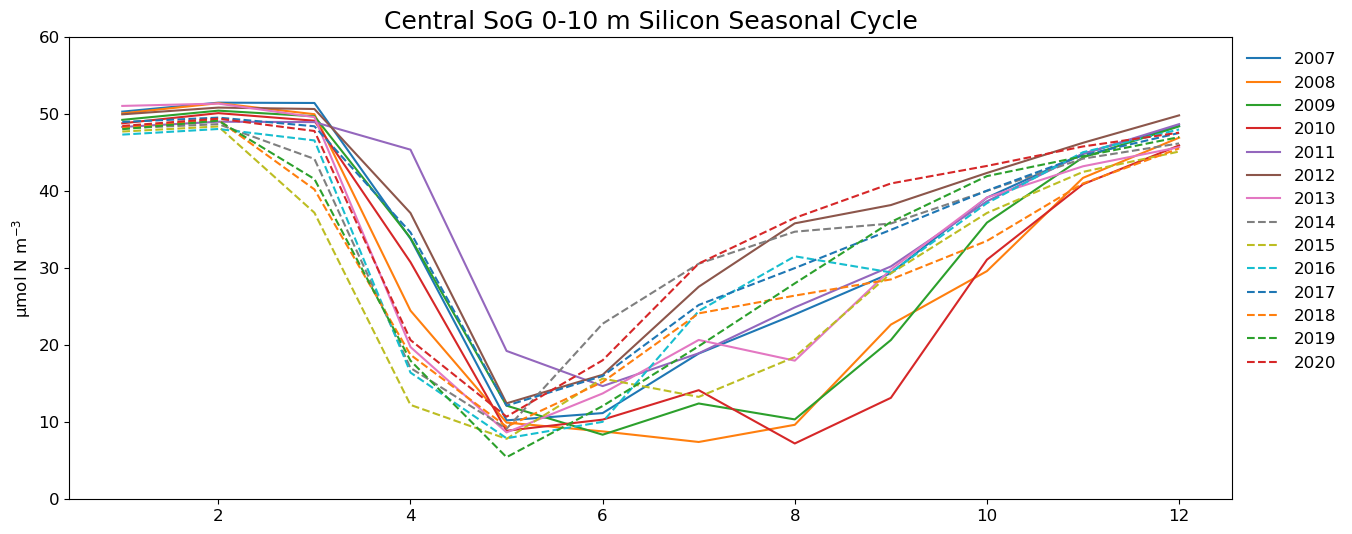

In [4]:
monthly_array_silicon_depthint_slice[monthly_array_silicon_depthint_slice == 0 ] = np.nan
monthly_array_silicon_depthint_slicemean = \
np.nanmean(np.nanmean(monthly_array_silicon_depthint_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_silicon_depthint_slicemean))


#plot monthly means for 5 years
fig, ax = plt.subplots(figsize=(15, 6))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


for i in range(0,7):
    ax.plot(np.arange(1,13), monthly_array_silicon_depthint_slicemean[i,:],label=2007+i)
    ax.set_title('Central SoG Silicon Seasonal Cycle',fontsize=18)
    ax.legend(frameon=False)
    ax.set_ylim(0,500)
    ax.set_ylabel('\u03bcmol N')
   
for i in range(7,14):
    ax.plot(np.arange(1,13), monthly_array_silicon_depthint_slicemean[i,:],linestyle='--',label=2007+i)
    ax.set_title('Central SoG 0-10 m Silicon Seasonal Cycle',fontsize=18)
    ax.legend(frameon=False,bbox_to_anchor=(1, 1))
    ax.set_ylim(0,60)
    ax.set_ylabel('\u03bcmol N m$^{-3}$')

### Select 4 warmest and 4 coldest years; leave NPGO "neutral" years out

In [5]:
#2008, 2010, 2011, 2012
NPGO_C=(((+monthly_array_silicon_depthint_slicemean[1,:]+\
        monthly_array_silicon_depthint_slicemean[3,:]+\
        monthly_array_silicon_depthint_slicemean[4,:]+monthly_array_silicon_depthint_slicemean[5,:])/4))

In [6]:
#2015, 2018, 2019, 2020
NPGO_W=(((monthly_array_silicon_depthint_slicemean[8,:]+\
        monthly_array_silicon_depthint_slicemean[11,:]+monthly_array_silicon_depthint_slicemean[12,:]+\
        monthly_array_silicon_depthint_slicemean[13,:])/4))

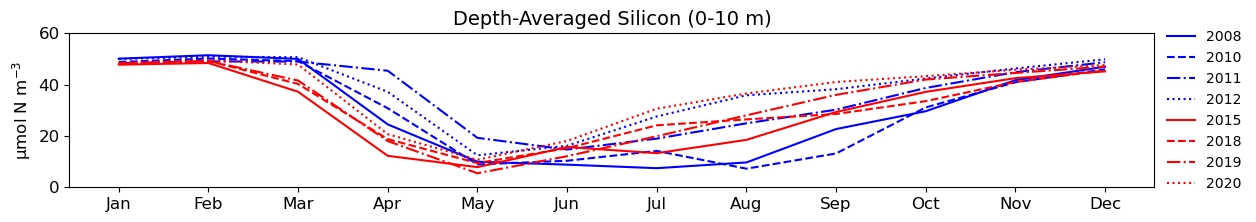

In [7]:
## Plot the coldest and warmest years only; Supp Fig. S3

fig, ax = plt.subplots(figsize=(14, 2))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"]

ax.plot(xticks, monthly_array_silicon_depthint_slicemean[1,:],color='b',linestyle='-',label='2008')
ax.plot(xticks, monthly_array_silicon_depthint_slicemean[3,:],color='b',linestyle='--',label='2010')
ax.plot(xticks, monthly_array_silicon_depthint_slicemean[4,:],color='b',linestyle='-.',label='2011')
ax.plot(xticks, monthly_array_silicon_depthint_slicemean[5,:],color='b',linestyle=':',label='2012')
ax.plot(xticks, monthly_array_silicon_depthint_slicemean[8,:],color='r',linestyle='-',label='2015')
ax.plot(xticks, monthly_array_silicon_depthint_slicemean[11,:],color='r',linestyle='--',label='2018')
ax.plot(xticks, monthly_array_silicon_depthint_slicemean[12,:],color='r',linestyle='-.',label='2019')
ax.plot(xticks, monthly_array_silicon_depthint_slicemean[13,:],color='r',linestyle=':',label='2020')

ax.set_title('Depth-Averaged Silicon (0-10 m)',fontsize=14)
ax.legend(frameon=False,loc='center left', bbox_to_anchor=(1, 0.5),fontsize=10)
ax.set_ylim(0,60)
ax.set_ylabel('\u03bcmol N m$^{-3}$')
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
#ax.set_xticklabels([])

In [8]:
### Data for Figure 3: Calculate monthly standard error values for cold and warm years

In [9]:
NPGO_W_years=[monthly_array_silicon_depthint_slicemean[8,:],monthly_array_silicon_depthint_slicemean[11,:],monthly_array_silicon_depthint_slicemean[12,:],monthly_array_silicon_depthint_slicemean[13,:]]

In [10]:
sem(NPGO_W_years)

array([0.15859578, 0.22383724, 2.23142111, 1.81312742, 1.13237958,
       1.22082575, 3.64146794, 3.7030475 , 2.94864974, 2.23880227,
       1.06462325, 0.58527652])

In [11]:
NPGO_W_SEM=[0.2275976 , 0.33726364, 1.34646478, 1.47386724, 0.67683366,
       0.9930824 , 2.5463565 , 2.47506929, 2.05869284, 1.55110053,
       0.78331193, 0.5134743]

In [12]:
NPGO_C_years=[monthly_array_silicon_depthint_slicemean[1,:],
        monthly_array_silicon_depthint_slicemean[3,:],
        monthly_array_silicon_depthint_slicemean[4,:],monthly_array_silicon_depthint_slicemean[5,:]]

In [13]:
sem(NPGO_C_years)

array([0.43386343, 0.51882438, 0.39442422, 4.46979199, 2.32988638,
       1.74410358, 4.23866279, 6.72599458, 5.3425027 , 3.04416389,
       1.27210777, 0.87401607])

In [14]:
NPGO_C_SEM=[0.41073373, 0.50735594, 0.36454512, 2.70717051, 2.41409781,
       1.4875741 , 2.96242003, 4.76044281, 3.73065234, 2.24611888,
       1.19261423, 0.90892549]

In [15]:
NPGO_C

array([49.32323968, 50.37285438, 49.70968201, 34.4677553 , 12.64501118,
       12.50659466, 17.0418997 , 19.41833774, 26.0765079 , 35.45568785,
       43.45061737, 47.87295499])

Text(-0.4, 50, '(h)')

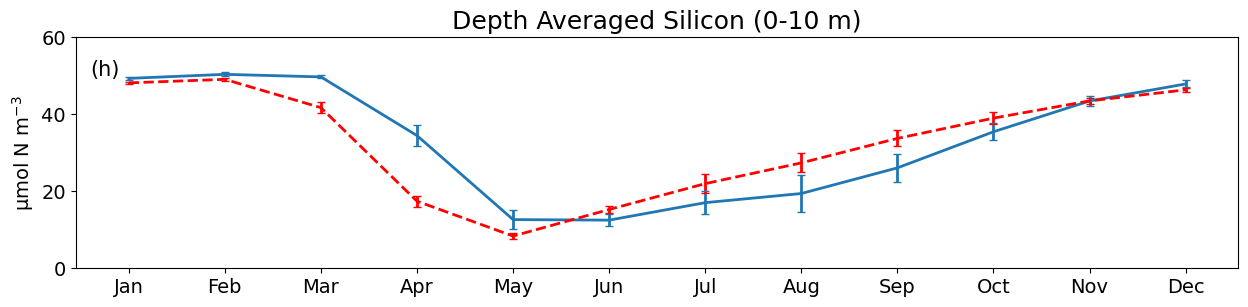

In [17]:
## Preliminary Figure 3h

fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"]
border = 0.25

ax.errorbar(xticks, NPGO_C, yerr= NPGO_C_SEM, capsize=3,label='NPGO+ coldest',linewidth=2)
ax.errorbar(xticks, NPGO_W,yerr= NPGO_W_SEM, capsize=3,linestyle='--',label='NPGO- warmest',color='r',linewidth=2)
ax.set_title('Depth Averaged Silicon (0-10 m)',fontsize=18)
ax.legend((),frameon=False)
ax.set_ylim(0,60)
ax.set_ylabel('\u03bcmol N m$^{-3}$',fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
#ax.set_xticklabels([])

a=2
b=5
c=5
d=8

ax.text(-.4, 50, '(h)', fontsize=15,  color='k')

#plt.fill([a, a, b, b], [0, 25, 25, 0], color = 'lightgreen', alpha = 0.1)
#plt.fill([c, c, d, d], [0, 25, 25, 0], color = 'wheat', alpha = 0.2)

#plt.savefig('Fig3h_Silicon.png', bbox_inches='tight',dpi=1000,transparent=False)

### Data for calculating seasonal mean values for box plots

In [18]:
Spring_C=(((monthly_array_silicon_depthint_slicemean[(1,3,4,5),2]+
        monthly_array_silicon_depthint_slicemean[(1,3,4,5),3]+monthly_array_silicon_depthint_slicemean[(1,3,4,5),4]))/3) #

In [19]:
Spring_W=(((monthly_array_silicon_depthint_slicemean[(8,11,12,13),2]+
        monthly_array_silicon_depthint_slicemean[(8,11,12,13),3]+monthly_array_silicon_depthint_slicemean[(8,11,12,13),4]))/3) #

In [20]:
Summer_C=(((monthly_array_silicon_depthint_slicemean[(1,3,4,5),5]+
        monthly_array_silicon_depthint_slicemean[(1,3,4,5),6]+monthly_array_silicon_depthint_slicemean[(1,3,4,5),7]))/3) #

In [21]:
Summer_C

array([ 8.64361296, 10.58562337, 19.52603833, 26.5338348 ])

In [22]:
Summer_W=(((monthly_array_silicon_depthint_slicemean[(8,11,12,13),5]+
        monthly_array_silicon_depthint_slicemean[(8,11,12,13),6]+monthly_array_silicon_depthint_slicemean[(8,11,12,13),7]))/3) #

In [23]:
Summer_W

array([15.81506055, 21.94194099, 20.0092991 , 28.40216005])

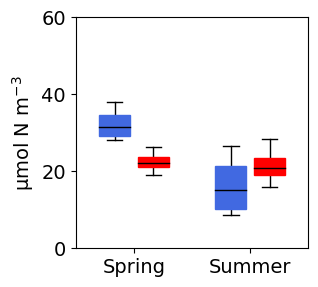

In [24]:
## New Plots with 2015 instead of 2017
def color_boxplot(data, color, pos=[0], ax=None):
    ax = ax or plt.gca()
    bp = ax.boxplot(data, patch_artist=True,  showmeans=False, positions=pos,widths=0.4)
    for item in ['boxes']:
        plt.setp(bp[item], color=color)
    for item in ['whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[item], color='k')


data1 = [Spring_C]
data2 = [Spring_W]
data3 = [Summer_C]
data4 = [Summer_W]

fig, ax = plt.subplots(figsize=(3,3))
bp1 = color_boxplot(data1, 'royalblue', [1])
bp2 = color_boxplot(data2, 'r', [1.5])
bp3 = color_boxplot(data3, 'royalblue', [2.5])
bp4 = color_boxplot(data4, 'r', [3])
#ax.autoscale()
ax.set(xticks=[1.25,2.75], xticklabels=['Spring','Summer'])
ax.set_ylim(0,60)
ax.set_ylabel('\u03bcmol N m$^{-3}$',fontsize=14)

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
#ax.legend([bp1["boxes"], bp2["boxes"], ['A', 'B'], loc='upper right')

#plt.savefig('Fig3h_SiliconBoxplots.png', bbox_inches='tight',dpi=1000,transparent=True)

plt.show()

In [25]:
Spring_C.mean()

32.27414949473416

In [27]:
Spring_W.mean()

22.503918427163622

### t tests for differences between spring and summer of cold and warm years

In [28]:
stats.ttest_ind(a=Spring_C, b=Spring_W, equal_var=True)

Ttest_indResult(statistic=3.683377722885707, pvalue=0.010289308961130304)

In [29]:
stats.ttest_ind(a=Summer_C, b=Summer_W, equal_var=True)

Ttest_indResult(statistic=-1.0640553069608663, pvalue=0.32824021673820547)